In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
from datetime import datetime
from nltk.corpus import stopwords 
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize 
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from xgboost import XGBClassifier

# First things first

Loading the data

In [2]:

data = pd.read_csv('../raw_data/mbti_1.csv')

data

type                                              posts
0     INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1     ENTP  'I'm finding the lack of me in these posts ver...
2     INTP  'Good one  _____   https://www.youtube.com/wat...
3     INTJ  'Dear INTP,   I enjoyed our conversation the o...
4     ENTJ  'You're fired.|||That's another silly misconce...
...    ...                                                ...
8670  ISFP  'https://www.youtube.com/watch?v=t8edHB_h908||...
8671  ENFP  'So...if this thread already exists someplace ...
8672  INTP  'So many questions when i do these things.  I ...
8673  INFP  'I am very conflicted right now when it comes ...
8674  INFP  'It has been too long since I have been on per...

[8675 rows x 2 columns]

Now, let's inspect the data and see what it have for us

In [3]:
data.describe()

type                                              posts
count   8675                                               8675
unique    16                                               8675
top     INFP  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq    1832                                                  1

In [4]:
data.type.value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [5]:
data['type'].nunique()

16

So, we have the 16 types correctly assigned as a classifier ✔

And lets see the distribution for them

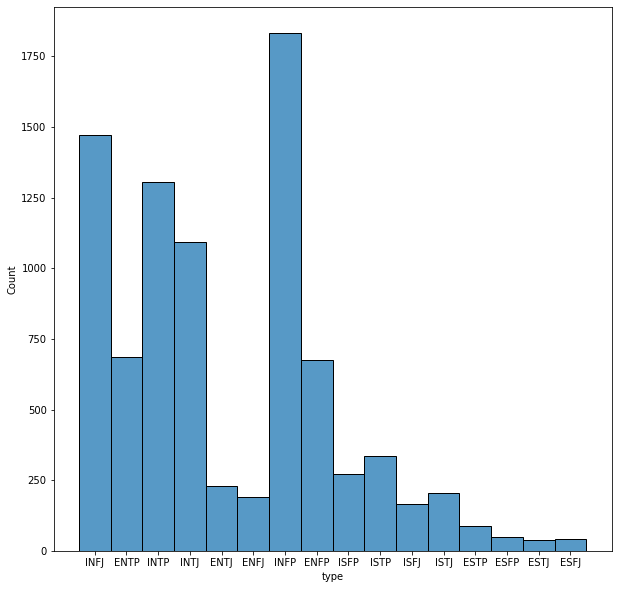

In [6]:
plt.figure(figsize=(10,10))
sns.histplot(data['type']);

And finally let's take a look into the content of the posts

In [7]:
data['posts'][0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

Just as described in the documentation of the data, here we have the last 50 things they have posted (Each entry separated by "|||" (3 pipe characters)), maybe we have a better performance splitting it into a more observations and try to add more weight for each classification

That's the code to split the comments into more rows, but seems to have a poor performance in the classification
``` 
my_list = []

for idi, p in data.to_numpy():
    post = p.split('|||')
    my_df = pd.DataFrame(post)
    my_df['type'] = idi
    my_list.append(my_df)
    
full_data = pd.concat(my_list)

full_data = full_data.rename(columns={0: 'post', 'type': 'type'}) 
```

## Preprocessing for NLP

First let's add a new column counting the URLs in posts to have a reference how much links this person use

In [8]:
data['links counts'] = data.posts.str.count('https?://[^\s<>"]+|www\.[^\s<>"]+')

Let's treat the strings for NLP analysis

In [9]:
def clean(text):
    sentence = re.sub('https?://[^\s<>"]+|www\.[^\s<>"]+', ' ',
                      text)  # Remove links
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, ' ')  # Remove Punctuation
    lowercased = sentence.lower()  # Lower Case
    tokenized = word_tokenize(lowercased)  # Tokenize
    words_only = [word for word in tokenized
                  if word.isalpha()]  # Remove numbers
    stop_words = set(stopwords.words('english'))  # Make stopword list
    without_stopwords = [
        word for word in words_only if not word in stop_words
    ]  # Remove Stop Words
    lemma = WordNetLemmatizer()  # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word)
                  for word in without_stopwords]  # Lemmatize
    return " ".join(lemmatized)  # Return as one string for post


# Apply to all texts
data['clean_text'] = data.posts.apply(clean)
data['clean_text'] = data['clean_text'].astype('str')

data.head()

type                                              posts  links counts  \
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...            18   
1  ENTP  'I'm finding the lack of me in these posts ver...             8   
2  INTP  'Good one  _____   https://www.youtube.com/wat...             5   
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...             2   
4  ENTJ  'You're fired.|||That's another silly misconce...             5   

                                          clean_text  
0  intj moment sportscenter top ten play prank li...  
1  finding lack post alarming sex boring position...  
2  good one course say know blessing curse absolu...  
3  dear intp enjoyed conversation day esoteric ga...  
4  fired another silly misconception approaching ...

Let's try to add a feature engineering to see if it helps the classification

In [10]:
def vocab_richness(text):
    tokens = word_tokenize(text)
    total_length = len(tokens)
    unique_words = set(tokens)
    unique_word_length = len(unique_words)
    return unique_word_length/total_length

data['vocab richness'] = data.posts.apply(vocab_richness)

data

type                                              posts  links counts  \
0     INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...            18   
1     ENTP  'I'm finding the lack of me in these posts ver...             8   
2     INTP  'Good one  _____   https://www.youtube.com/wat...             5   
3     INTJ  'Dear INTP,   I enjoyed our conversation the o...             2   
4     ENTJ  'You're fired.|||That's another silly misconce...             5   
...    ...                                                ...           ...   
8670  ISFP  'https://www.youtube.com/watch?v=t8edHB_h908||...             7   
8671  ENFP  'So...if this thread already exists someplace ...             2   
8672  INTP  'So many questions when i do these things.  I ...             2   
8673  INFP  'I am very conflicted right now when it comes ...             0   
8674  INFP  'It has been too long since I have been on per...             3   

                                             clean_text  vocab richness  
0     intj moment sportscenter top ten play prank li...        0.538462  
1     finding lack post alarming sex boring position...        0.401968  
2     good one course say know blessing curse absolu...        0.476144  
3     dear intp enjoyed conversation day esoteric ga...        0.410374  
4     fired another silly misconception approaching ...        0.447952  
...                                                 ...             ...  
8670  always think cat fi doms reason website become...        0.454451  
8671  thread already exists someplace else heck dele...        0.349854  
8672  many question thing would take purple pill pic...        0.478970  
8673  conflicted right come wanting child honestly m...        0.320827  
8674  long since personalitycafe although seem chang...        0.344465  

[8675 rows x 5 columns]

In [11]:
data['extraversion'] = data['type'].apply(lambda x : 0 if 'I'in str(x) else 1)
data['sensitivity'] = data['type'].apply(lambda x : 0 if 'N'in str(x) else 1)
data['feel'] = data['type'].apply(lambda x : 0 if 'T'in str(x) else 1)
data['judge'] = data['type'].apply(lambda x : 0 if 'P'in str(x) else 1)

In [ ]:
data

Now let's normalize the data to avoid the bias created by the huge difference in the number of personalities

## Bag-of-Words modeling

Ok! Now lets make a bag-of-words to vectorize the words to put it in the models:

In [12]:
vectorizer = TfidfVectorizer(ngram_range = (2,2), min_df=0.01, max_df = 0.05)

X_bow = vectorizer.fit_transform(data.clean_text)

In [13]:
X_sum = X_bow.sum(axis=0)
score_list = X_sum.tolist()[0]

# Get the word and associated weight
score_df = pd.DataFrame({"word": vectorizer.get_feature_names_out(), "score":score_list})
score_df
# Sort
score_df.sort_values("score", ascending = False, inplace =True)
# Display the sorted list
score_df.head(20)

word      score
2368  using tapatalk  97.674933
2465   welcome forum  77.869015
2632         yes yes  56.719712
1822      small talk  53.595177
286   enneagram type  51.525494
1611       read book  50.987394
603        good luck  49.796085
1939      stuff like  49.561178
1794     self esteem  49.533997
328     every single  48.630049
2498      well think  48.364742
1549      point view  48.350818
1254    myers briggs  48.334310
2588     would think  48.185936
369      feel better  48.135105
1598       quite bit  48.107330
815        know feel  48.054205
999        like said  47.852131
831        know know  47.467100
2561        would go  47.287212

We can compute the most commons words for each type of MBTI

In [14]:
types = ['INTP', 'INTJ', 'ENTJ', 'ENTP', 'INFJ', 'INFP', 'ENFJ', 'ENFP', 'ISTJ', 'ISFJ', 'ESTJ',
         'ESFJ', 'ISTP', 'ISFP', 'ESTP', 'ESFP']
 
def words_count(data, mbti):
    df = data[data['type'].isin([mbti])]
    return df

my_list = []

for t in types:
    my_df = words_count(data, t)
    my_list.append(my_df)

words_for_type = pd.concat(my_list)

words_for_type

type                                              posts  links counts  \
2     INTP  'Good one  _____   https://www.youtube.com/wat...             5   
9     INTP  'https://www.youtube.com/watch?v=w8-egj0y8Qs||...             7   
14    INTP  'Basically this...  https://youtu.be/1pH5c1Jkh...             3   
15    INTP  'Your comment screams INTJ, bro. Especially th...             1   
20    INTP  'Steve Job's was recognized for his striving f...             1   
...    ...                                                ...           ...   
7366  ESFP  'Marathoning anime about MMO's. Sword Art Onli...             1   
7376  ESFP  'I think she is a INFJ..What do you guys think...             0   
7530  ESFP  'The Social 9 description fit me better than p...            12   
7804  ESFP  'Here, have an INFJ.|||Lol. Nope.|||Rule 1: Ev...             1   
8426  ESFP  - Black bean/guacamole/diced tomato/onion/whea...             2   

                                             clean_text  vocab richness  \
2     good one course say know blessing curse absolu...        0.476144   
9     position actually let go person due various re...        0.429535   
14    basically cheezburgr fond top hat certainly ex...        0.462076   
15    comment scream intj bro especially useless par...        0.408638   
20    steve job recognized striving efficiency pract...        0.453775   
...                                                 ...             ...   
7366  marathoning anime mmo sword art online game li...        0.410191   
7376  think infj guy think dear infj dating almost y...        0.438596   
7530  social description fit better probably descrip...        0.439457   
7804  infj lol nope rule everybody sensor intuitive ...        0.481106   
8426  black bean guacamole diced tomato onion wheat ...        0.409212   

      extraversion  sensitivity  feel  judge  
2                0            0     0      0  
9                0            0     0      0  
14               0            0     0      0  
15               0            0     0      0  
20               0            0     0      0  
...            ...          ...   ...    ...  
7366             1            1     1      0  
7376             1            1     1      0  
7530             1            1     1      0  
7804             1            1     1      0  
8426             1            1     1      0  

[8675 rows x 9 columns]

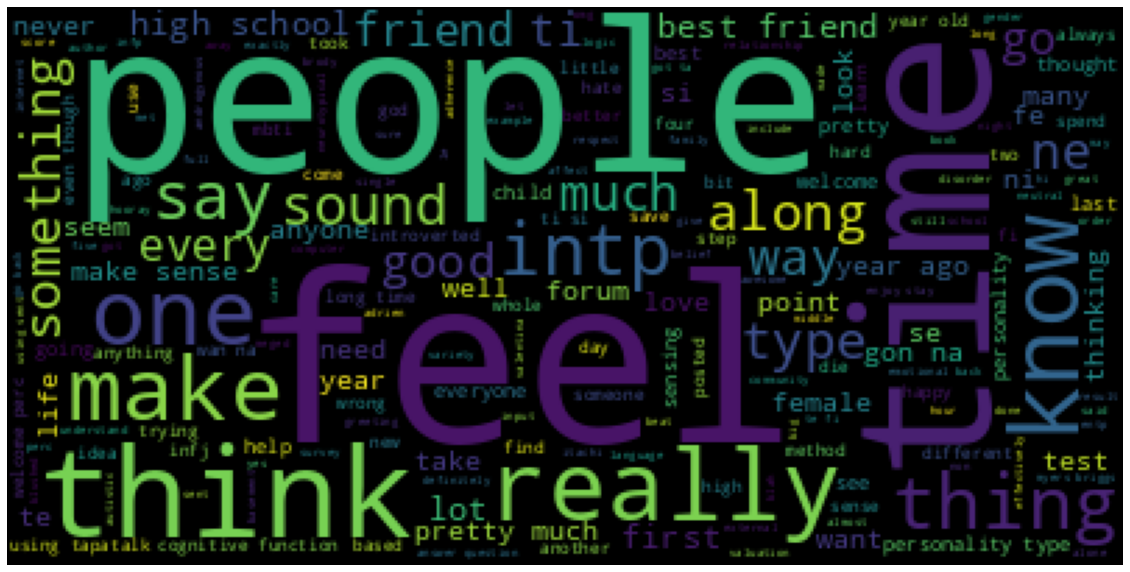

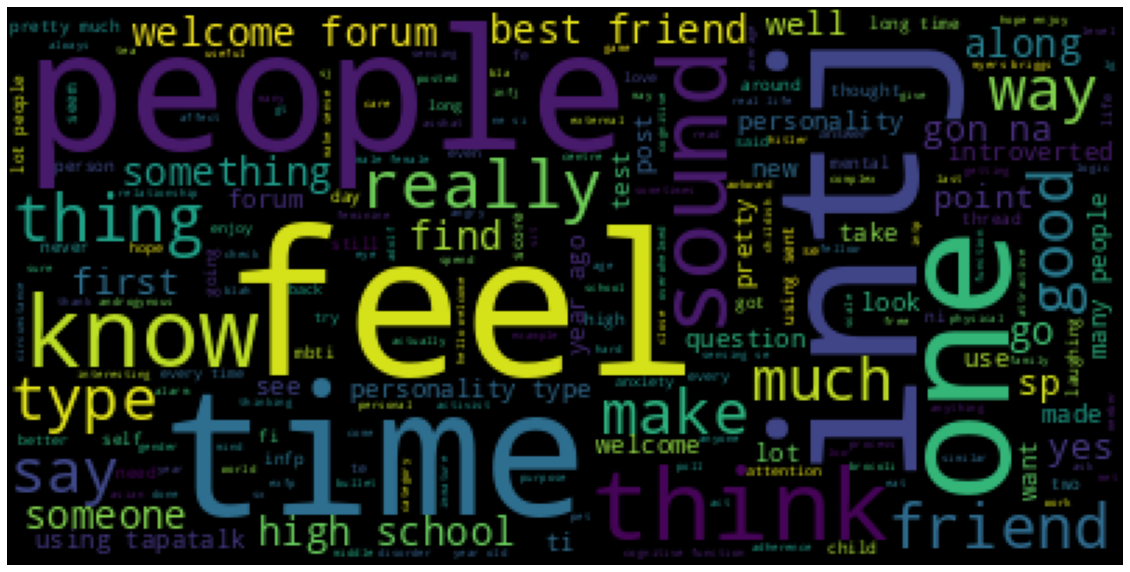

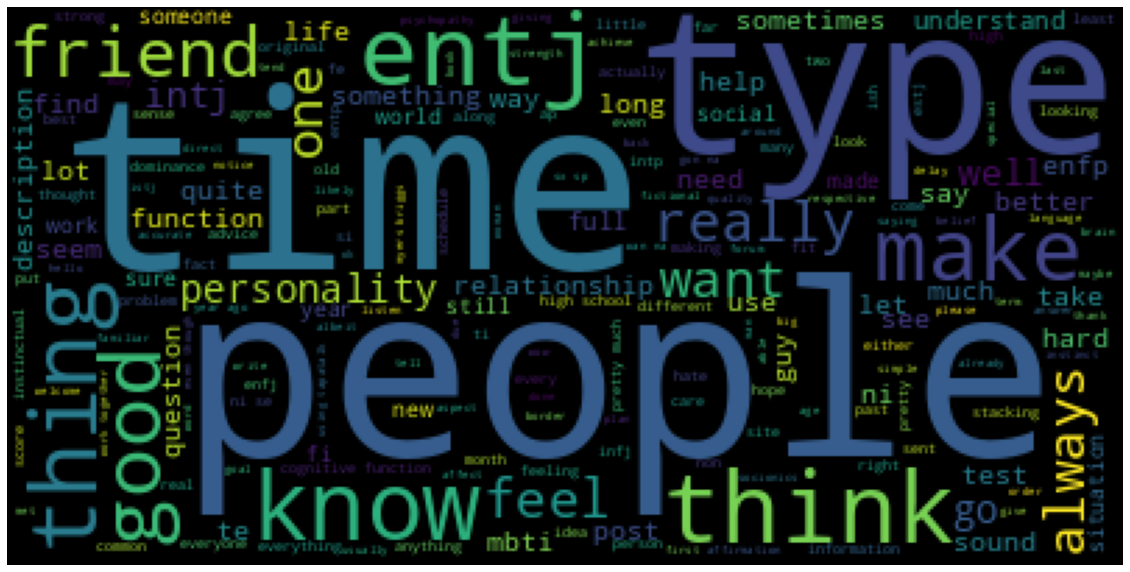

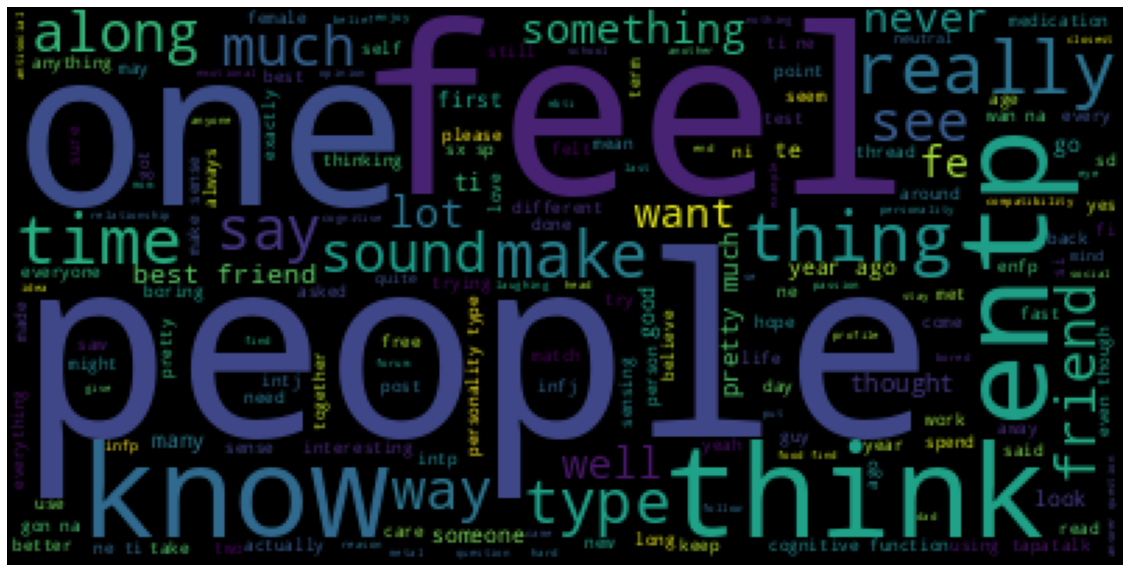

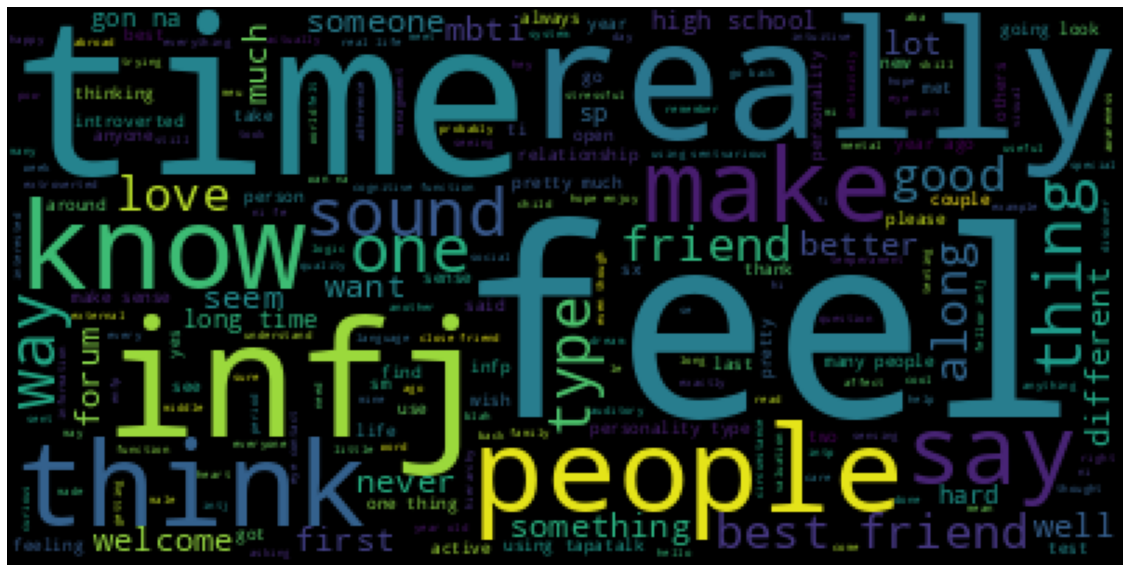

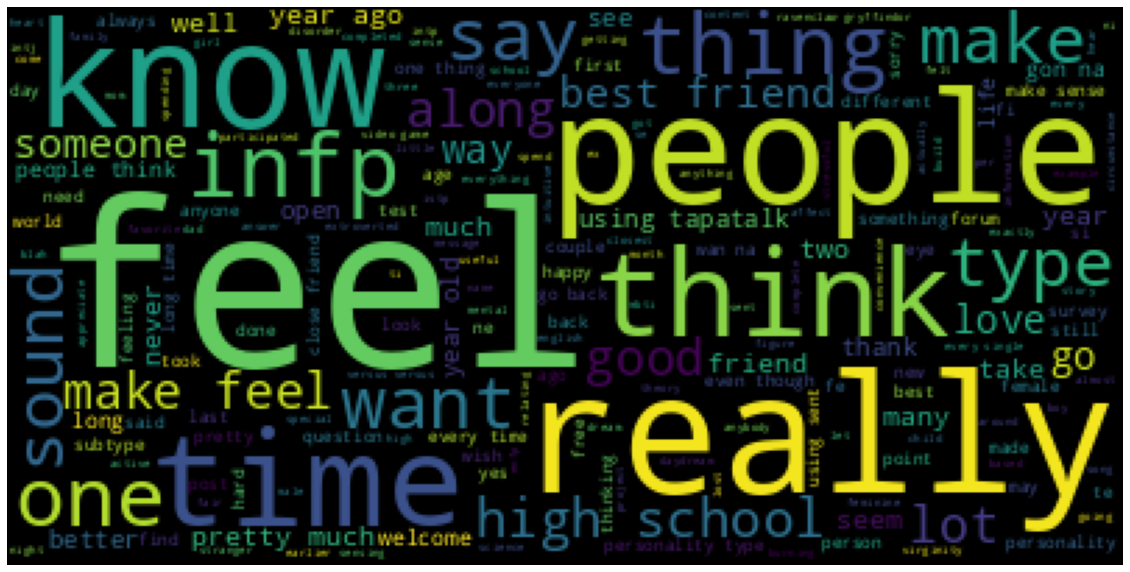

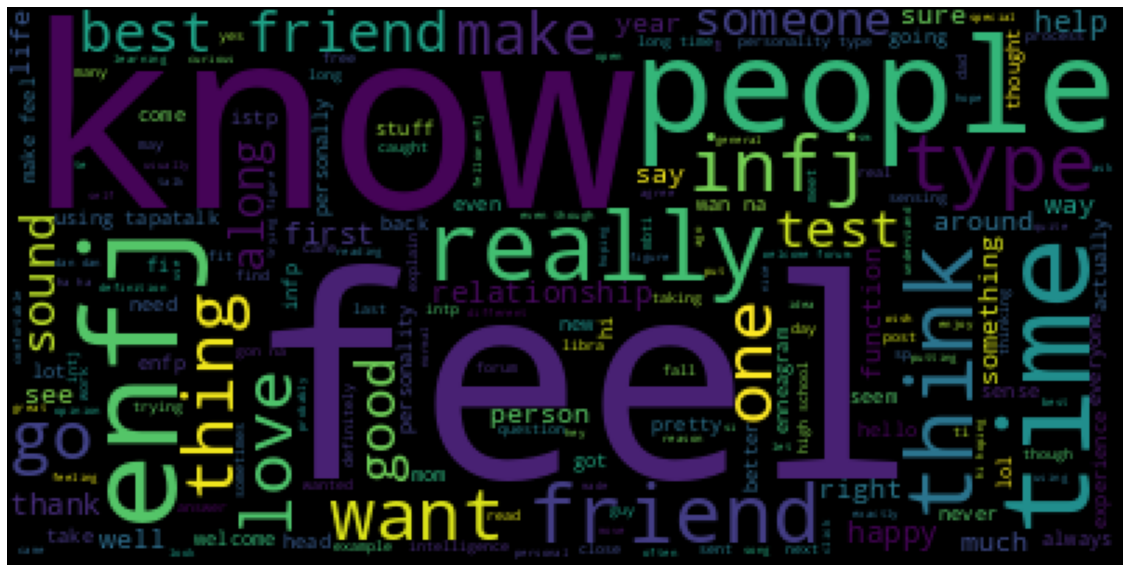

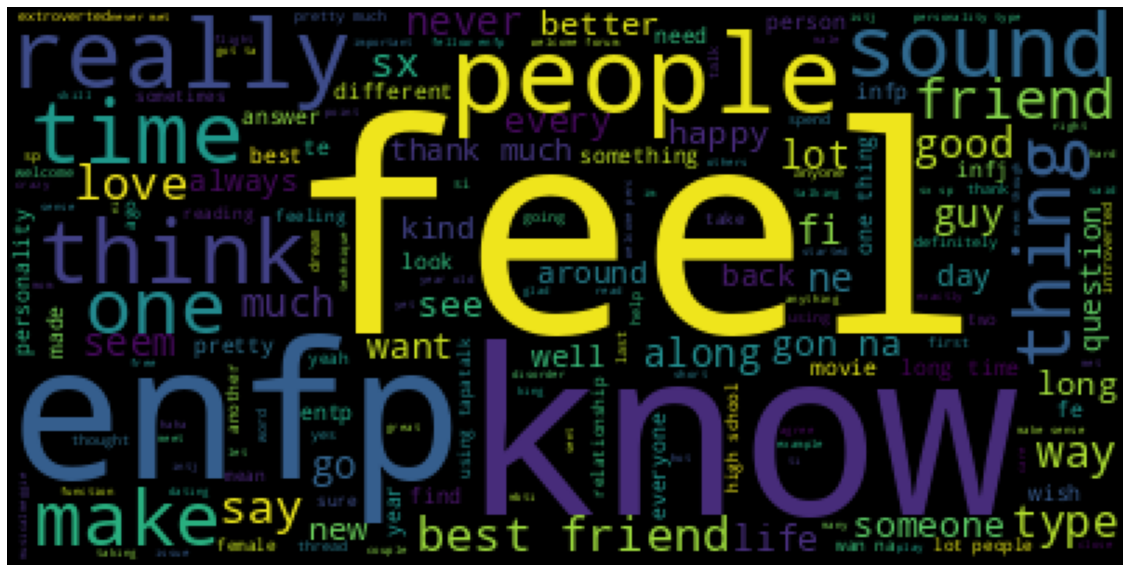

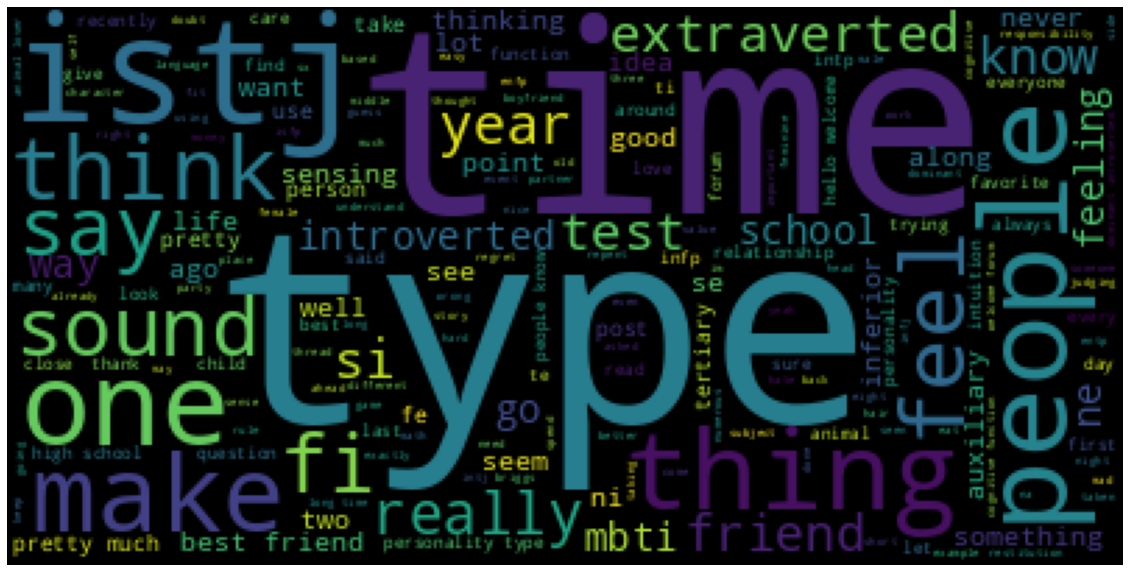

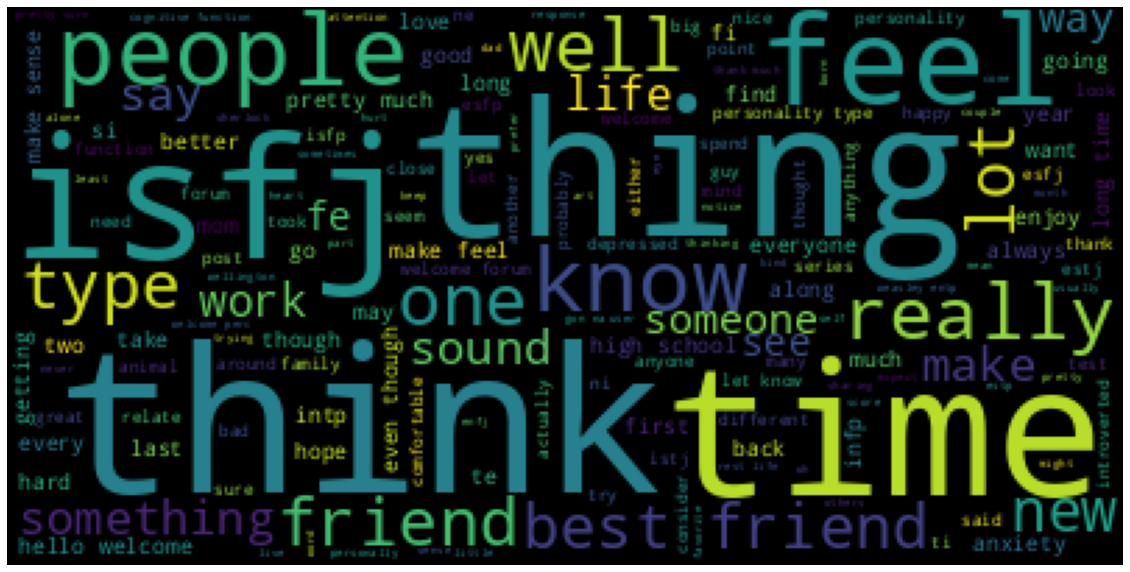

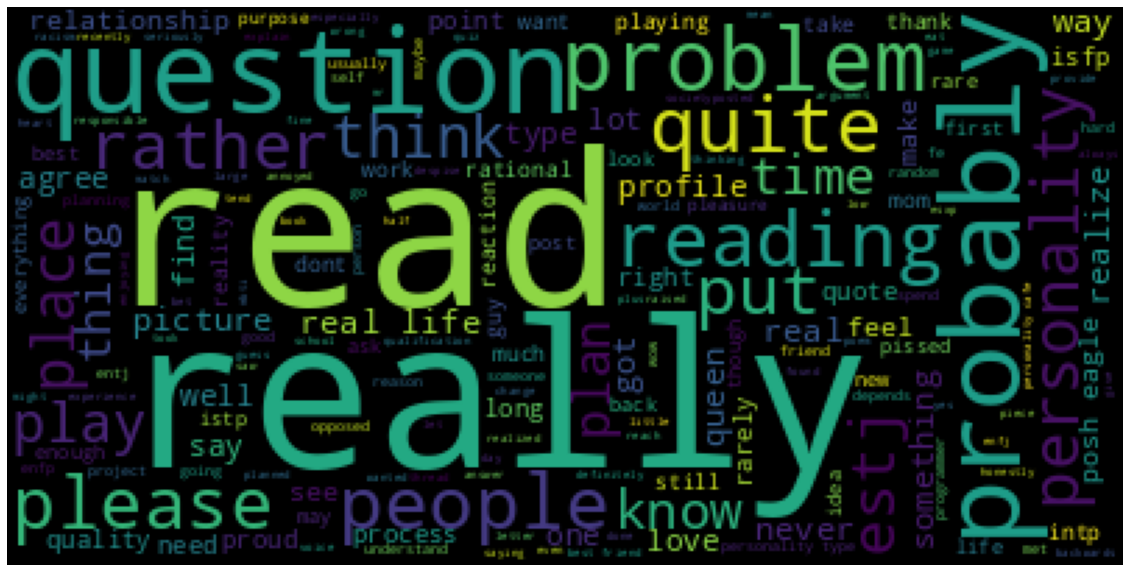

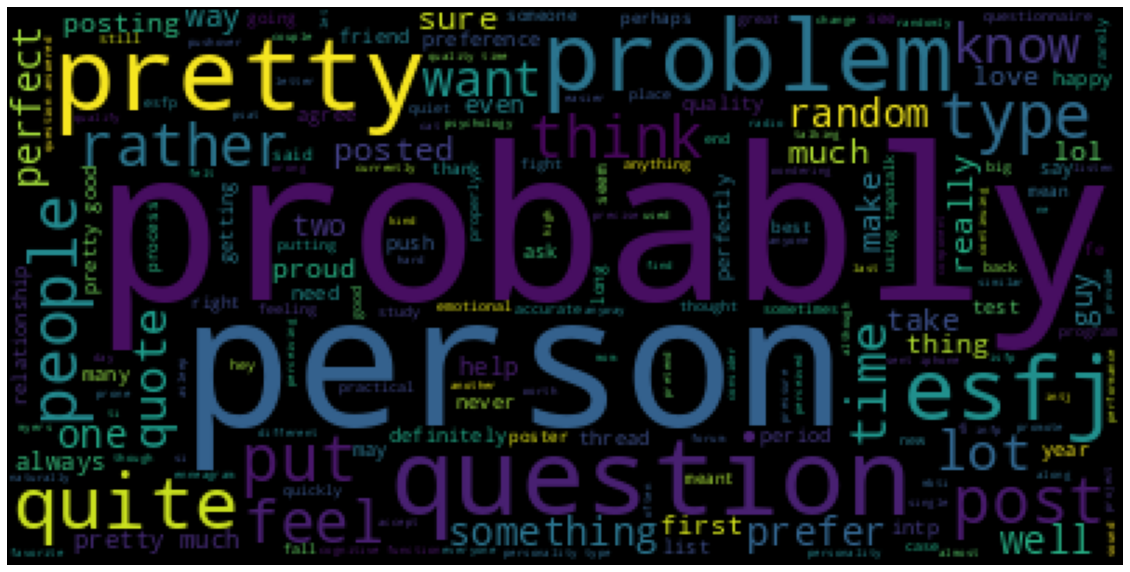

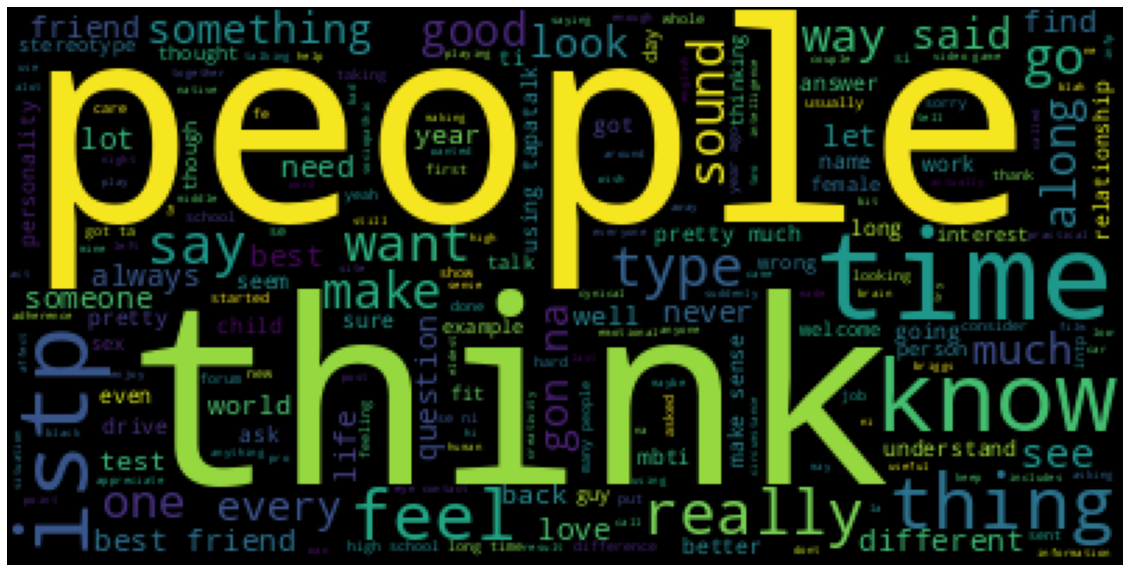

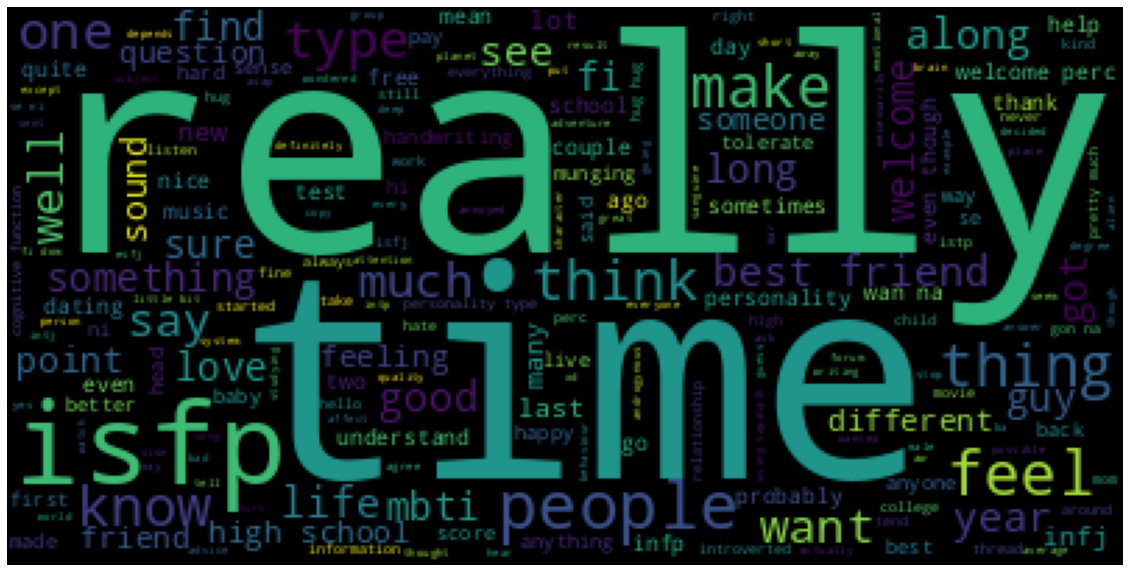

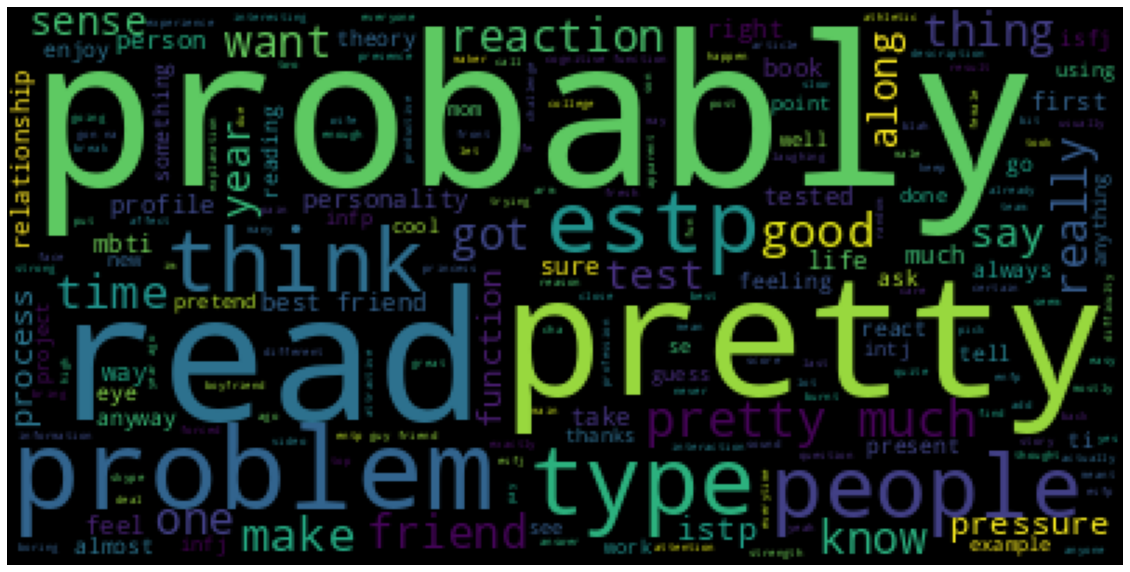

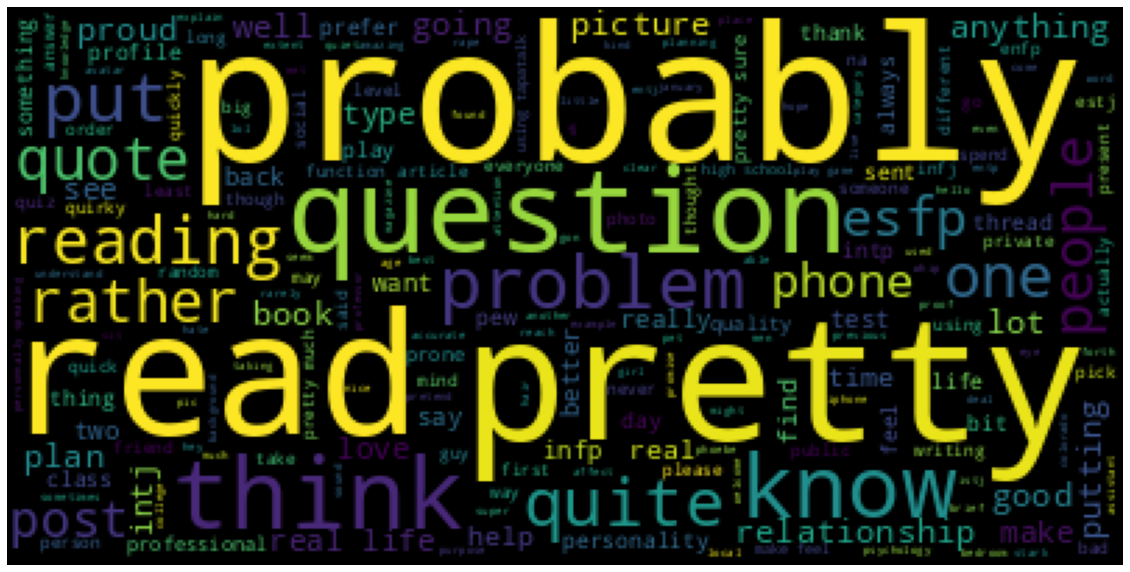

In [15]:
for typedf in my_list:
    vectorizer = TfidfVectorizer(ngram_range=(3,3) , min_df = 0, max_df=0.9, max_features=1000)
    X_bow = vectorizer.fit_transform(typedf['clean_text'])
    feature_names = vectorizer.get_feature_names_out()
    wc = WordCloud()
    wc.generate(' '.join(word for word in feature_names ))
    plt.figure(figsize=(20,15))
    plt.axis('off')
    plt.imshow(wc);

Well, it's seems we can a big job to improve the accuracy of the model. Let's try apply some improvements in the process of cleaning the data.

# Models

## Tuned MultinomialNB

In [16]:
vectorizer = TfidfVectorizer(max_features=1000)

X_bow = vectorizer.fit_transform(data.clean_text)


cv_nb = cross_validate( MultinomialNB(), X_bow, data.type, scoring = "accuracy")

cv_nb['test_score'].mean()

0.43342939481268006

In [17]:
vectorizer = TfidfVectorizer(ngram_range=(3,3) , min_df = 0, max_df=0.9, max_features=5000)

X_bow = vectorizer.fit_transform(data.clean_text)

cv_nb = cross_validate(MultinomialNB(), X_bow, data.type, scoring="accuracy")

cv_nb['test_score'].mean()

0.2501440922190202

Yeah, well, let's try others classifiers to see what we can get

##  XGBoost Classifier

In [18]:
# Just to know how long thinks take

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [19]:
data[[f'v_{i}' for i in range(5000)]] = X_bow.toarray()

/home/piratkriegen/.pyenv/versions/3.8.12/envs/linkedin_project/lib/python3.8/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


In [20]:
data_2 = data.copy()
data_2 = data_2.drop(columns=['posts','clean_text'])

In [21]:


X_train, X_test, y_train, y_test = train_test_split(
    data_2.drop(columns='type'), data_2['type'], test_size=0.2, random_state=42)


model = XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy Of Model 2 is :",accuracy_score(y_pred,y_test)*100)

/home/piratkriegen/.pyenv/versions/3.8.12/envs/linkedin_project/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Of Model 2 is : 100.0


 Doing a gridsearch with XGBoost Classifier

In [22]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [23]:
xgb = XGBClassifier(gpu_id=0,tree_method='gpu_hist',max_depth=5,n_estimators=50,learning_rate=0.1, objective='binary:logistic',
                    silent=True, nthread=1)

In [28]:
folds = 5
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
search = random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[16:22:57] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:23:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3] END colsample_bytree=1.0, gamma=5, max_depth=3, min_child_weight=5, subsample=1.0;, score=nan total time=41.6min
[17:04:35] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passe

/home/piratkriegen/.pyenv/versions/3.8.12/envs/linkedin_project/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/piratkriegen/.pyenv/versions/3.8.12/envs/linkedin_project/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/piratkriegen/.pyenv/versions/3.8.12/envs/linkedin_project/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)

KeyboardInterrupt: 